# Пример работы с моделями DPD

В этом ноутбуке вводятся различные модели, в порядке увеличения сложности. Для каждой на примере работы простого алгоритма оптимизации проверяется её релевантность.

## Установка библиотек
Чтобы приступить к работе, для начала нужно выполнить в консоли команду
`` pip3 install -r requirements.txt ``.
Далее, необходимо установить Graphviz следуя инструкциям [отсюда](https://graphviz.org/download/).

Когда установка необходимых библиотек завершена, можем импортировать их в ноутбук:

In [1]:
# Таймер
from timeit import default_timer

# Вычислительные пакеты
import torch
from torch.autograd import Variable
import torch_optimizer as optim
import numpy as np

# Блоки, из которых состоят модели
from blocks import AFIR, Polynomial, Delay, Prod_cmp

# Украшения жизни от стандартной библиотеки
from tqdm.notebook import tqdm
from collections import defaultdict

# Для загрузки данных сигнала
from scipy.io import loadmat

# Графики
import matplotlib.pyplot as plt

Устанавливаем настройки генераторов случайных чисел, выставляем используемое вычислительное устройство

In [2]:
np.random.seed(7)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.manual_seed(7)
torch.cuda.manual_seed(7)

cuda = torch.cuda.is_available()
if cuda:
    device = "cuda:0"
else:
    device = "cpu:0"

## Вспомогательные процедуры

Метрика качества normalized mean square error, которую мы будем измерять в децибелах:

$$ NMSE(y, y^*) = 10 \log_{10} \left\{ 
    \frac{\sum_{k=1}^m (y_k - y^*_k)^2}{\sum_{k=1}^m x_k^2}
\right\}\text{ dB}$$

In [3]:
def NMSE(input_sample, discrepancy):
    return 10. * torch.log10(
        discrepancy.norm(dim=1).square().sum() /
        input_sample.norm(dim=1).square().sum())

In [4]:
def update_log(log, iteration, db, loss, time):
    log['iter'].append(iteration)
    log['train_loss_db'].append(db.item())
    log['train_loss'].append(loss.item())
    log['time'].append(time)

In [5]:
def draw_spectrum(input_sample, desired, output=None):
    """
    Графики спектральной плотности мощности (power spectral density).
    Отображают спектральные характеристики исходного сигнала,
    идеально преобразованного сигнала и нашего приближения.
    """
    
    # Все тензоры, представляющие сигнал, отдельно хранят действительную и комплексную части,
    # поэтому мы суммируем их как (x[0, 0] + 1j * x[0, 1])
    
    plt.psd(input_sample.detach().cpu()[0, 0] + 1j * input_sample.detach().cpu()[0, 1], NFFT=2048, label="input")
    plt.psd(desired.detach().cpu()[0, 0] + 1j * desired.detach().cpu()[0, 1], NFFT=2048, label="desired")
    if output:
        plt.psd(output.detach().cpu()[0, 0] + 1j * output.detach().cpu()[0, 1], NFFT=2048, label="output")
    
    plt.legend()
    plt.show()

## Процедуры обучения и оценивания

In [6]:
# Оптимизируемой функцией стандартно выбираем mean square error
criterion = torch.nn.MSELoss()

In [7]:
def assess(X, Y, model, criterion=criterion, cuda=cuda, draw=False, save=None, report=True):
    """
    Значения функции потерь criterion и метрики качества NMSE
    при предыскажении целого отрезка сигнала X обученной моделью model
    в сравнении с идеально предыскажённым сигналом Y.
    """
    model.eval()
    
    with torch.no_grad():
        input_sample = Variable(X).permute(2, 1, 0)
        desired = Variable(Y).permute(2, 1, 0)

        if cuda:
            input_sample = input_sample.cuda()
            desired = desired.cuda()

        output = model(input_sample)
        if draw:
            draw_spectrum(input_sample, desired, output)
            if save is not None:
                plt.savefig(save + '.pdf')

        loss = criterion(output, desired)
        metric = NMSE(input_sample, output - desired)
        if report:
            print(f"Loss = {loss}\nNMSE = {metric}")
    
    return metric, loss 

In [8]:
def train_epoch(train_set, model, optimizer, criterion=criterion, cuda=cuda):
    """
    Обучаем модель model одним проходом по батчам, генерируемым train_set,
    используя метод оптимизации optimizer.
    """
    optimizer.zero_grad()
    
    for t, batch in enumerate(train_set):
        
        with torch.no_grad():
            input_sample = Variable(batch[..., :1]).permute(2, 1, 0)
            desired = Variable(batch[..., 1:]).permute(2, 1, 0)

            if cuda:
                input_sample = input_sample.cuda()
                desired = desired.cuda()
        
        loss = criterion(model(input_sample), desired)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()

In [19]:
def train(train_set, X, Y, model, optimizer, lr_scheduler, n_epochs, log_every=1):
    """
    Запускаем модель model обучаться на n_epochs проходов по всем батчам,
    используя метод оптимизации optimizer и менеджер размера шага lr_scheduler.
    """
    log = defaultdict(list)
    start_time = default_timer()
    
    db, loss = assess(X, Y, model)
    update_log(log, 0, db, loss, 0.)
    
    for t in tqdm(range(n_epochs)):
        model.train()
        
        train_epoch(train_set, model, optimizer)
        if lr_scheduler:
            lr_scheduler.step()

        if (t + 1) % log_every == 0:
            print("Epoch", t + 1)
            db, loss = assess(X, Y, model)
            update_log(log, t, db, loss, default_timer() - start_time)
    
    return log

In [10]:
def save_experiment(log, model, suffix=""):
    with open("log_" + suffix + ".pickle", 'wb') as logfile:
        pickle.dump(log, logfile)

    torch.save(model.state_dict(), "model_" + suffix + ".weights")

## Загрузка данных сигнала

In [11]:
filename = "BlackBoxData_80"

# Размер одного батча при обучении
batch_size = 1000

mat = loadmat(filename)

# Некоторая физически осмысленная предобработка сигнала
x = np.array(mat['x']).reshape(-1, 1) / 2**15
y = np.array(mat['y']).reshape(-1, 1) / 2**15

# Разделение комплексных величин на действительную и мнимую части
x_real, x_imag = torch.from_numpy(np.real(x)), torch.from_numpy(np.imag(x))
y_real, y_imag = torch.from_numpy(np.real(y)), torch.from_numpy(np.imag(y))

X = torch.DoubleTensor(torch.cat((x_real, x_imag), dim=1)).reshape(-1,2,1)
Y = torch.DoubleTensor(torch.cat((y_real, y_imag), dim=1)).reshape(-1,2,1)

# Генератор батчей
train_set = torch.utils.data.DataLoader(torch.cat((X, Y), dim=-1), batch_size=batch_size)

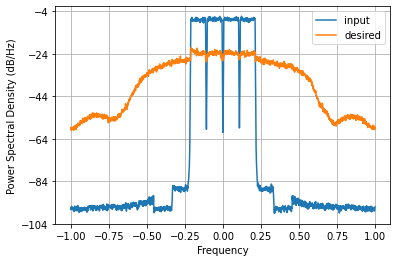

In [12]:
draw_spectrum(Variable(X).permute(2, 1, 0), Variable(Y).permute(2, 1, 0))

## Модели DPD

In [13]:
class Cell(torch.nn.Module):
    """
    Элементарная ячейка для каскадной модели
    в одном из наиболее простых видов.
    Выходом является произведение свёртки сдвинутого сигнала
    и свёртки нелинейно преобразованного сдвинутого сигнала. 
    """
    
    def __init__(self, conv_size=15, delay=0, order=8):
        super(Cell, self).__init__()
        
        # Свёртка для сигнала
        self.fir_1 = AFIR(conv_size, 0)
        
        # Свёртка для нелинейно преобразованного сигнала
        self.fir_2 = AFIR(conv_size, 0)
        
        # Общая задержка (сдвиг) сигнала
        self.delay = Delay(delay)
        
        # Нелинейное преобразование (в частности, полином порядка order)
        self.poly = Polynomial(order)
        
        # Модуль для покомпонентного произведения
        self.prod = Prod_cmp()
        
    def forward(self, x):
        out = self.delay(x)
        return self.prod(self.fir_1(out), self.fir_2(self.poly(out)))

In [14]:
class Layer(torch.nn.Module):
    """
    Однослойная модель с вариацией сдвигов сигнала.
    Выходом является сумма преобразований сигнала, 
    полученных различно настроенными элементарными ячейками.
    """
    
    def __init__(self, delays, width):
        super(Layer, self).__init__()
        
        self.cells = torch.nn.ModuleList()

        for i in range(width):
            self.cells.append(Cell(delay=delays[i]))

    def forward(self, x):
        out = torch.zeros_like(x)

        for i in range(len(self.cells)):
            out += self.cells[i](x)

        return out

In [15]:
class ResidualCascadeModel(torch.nn.Module):
    """
    Каскадная модель с пропускающими связями.
    Выходом является результат действия на сигнал
    композиции преобразований, задаваемых различно настроенными слоями,
    вместе с суммой этого результата и исходного сигнала.
    """
    
    def __init__(self, width, delays):
        super(ResidualCascadeModel, self).__init__()
        
        self.layers = torch.nn.ModuleList()
        
        for delay in delays:
            self.layers.append(Layer(delay, width))

    def forward(self, x):
        out = x.clone()
        
        for i in range(len(self.layers)):
            # Пропускающая связь добавляет x к выходу каждого слоя.
            # Возможна конфигурация с добавлением к выходу результата предыдущего слоя.
            out = self.layers[i](out) + x
        
        return out

## Оптимизация модели

Ниже приводятся результаты запусков ряда различных стохастических методов для каскадной модели. Используются произвольно выбранные настройки гиперпараметров модели и алгоритмов. Также используется простейшая схема модификации размеров шага с уеличением номера эпохи.

In [24]:
model = ResidualCascadeModel(
    width=5, 
    delays=[
        [0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9],
        [4, 3, 2, 1, 10]
    ]).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

adam_log = train(train_set, X, Y, model, optimizer, scheduler, n_epochs=20, log_every=1)

Loss = 0.032283653969738736
NMSE = 0.044426705659441776


Epoch 1
Loss = 0.00011470612042806528
NMSE = -24.449534217654374
Epoch 2
Loss = 5.2433192061734556e-05
NMSE = -27.84933715360006
Epoch 3
Loss = 4.39449889373367e-05
NMSE = -28.61630653659116
Epoch 4
Loss = 3.796848304455064e-05
NMSE = -29.25116767026969
Epoch 5
Loss = 3.438194099745132e-05
NMSE = -29.682096224429053
Epoch 6
Loss = 3.181817758009914e-05
NMSE = -30.018647117931742
Epoch 7
Loss = 2.9127964340096496e-05
NMSE = -30.402298788972537
Epoch 8
Loss = 2.6978608366984358e-05
NMSE = -30.735204693640807
Epoch 9
Loss = 2.6009549528963696e-05
NMSE = -30.894071826181655
Epoch 10
Loss = 2.5395031865988482e-05
NMSE = -30.997912510157015
Epoch 11
Loss = 2.2226158864917325e-05
NMSE = -31.576755989285594
Epoch 12
Loss = 2.1336009912539943e-05
NMSE = -31.754268086869317
Epoch 13
Loss = 2.082800331461014e-05
NMSE = -31.858923750203957
Epoch 14
Loss = 1.938204039448685e-05
NMSE = -32.17140518781786
Epoch 15
Loss = 1.8007210484844366e-05
NMSE = -32.490935721052196
Epoch 16
Loss = 1.744910900586

In [25]:
model = ResidualCascadeModel(
    width=5, 
    delays=[
        [0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9],
        [4, 3, 2, 1, 10]
    ]).to(device)

optimizer = torch.optim.RMSprop(model.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

rmsprop_log = train(train_set, X, Y, model, optimizer, scheduler, n_epochs=20, log_every=1)

Loss = 0.032283653969738736
NMSE = 0.044426705659441776


Epoch 1
Loss = 0.00016640291370742386
NMSE = -22.833790866407107
Epoch 2
Loss = 9.82044081851811e-05
NMSE = -25.124090303665593
Epoch 3
Loss = 7.27003809338296e-05
NMSE = -26.43003326667039
Epoch 4
Loss = 6.30506061640689e-05
NMSE = -27.048507469329408
Epoch 5
Loss = 5.541602833004547e-05
NMSE = -27.6090461648762
Epoch 6
Loss = 4.1806059888348e-05
NMSE = -28.833007747769074
Epoch 7
Loss = 4.057790508196828e-05
NMSE = -28.962503912107202
Epoch 8
Loss = 3.980707418917743e-05
NMSE = -29.045797549262403
Epoch 9
Loss = 4.3287442791437035e-05
NMSE = -28.681780825430213
Epoch 10
Loss = 5.339892132632321e-05
NMSE = -27.77007528895706
Epoch 11
Loss = 4.136192525821454e-05
NMSE = -28.879392676377933
Epoch 12
Loss = 3.598267096443412e-05
NMSE = -29.48446615605902
Epoch 13
Loss = 3.686626000841118e-05
NMSE = -29.379109314069936
Epoch 14
Loss = 3.480376142083388e-05
NMSE = -29.629138302254376
Epoch 15
Loss = 3.3347026360601233e-05
NMSE = -29.8148290030609
Epoch 16
Loss = 4.265997317410822e-05
NMSE 

In [26]:
model = ResidualCascadeModel(
    width=5, 
    delays=[
        [0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9],
        [4, 3, 2, 1, 10]
    ]).to(device)

adam = torch.optim.Adam(model.parameters(), lr=1e-2)
optimizer = optim.Lookahead(adam, k=5, alpha=0.5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

laadam_log = train(train_set, X, Y, model, optimizer, scheduler, n_epochs=20, log_every=1)

Loss = 0.032283653969738736
NMSE = 0.044426705659441776


Epoch 1
Loss = 0.00020661493978388324
NMSE = -21.89378292125707
Epoch 2
Loss = 9.670622768839356e-05
NMSE = -25.190855704555947
Epoch 3
Loss = 5.845347699194731e-05
NMSE = -27.37729663705624
Epoch 4
Loss = 4.9105935016897205e-05
NMSE = -28.13406028361421
Epoch 5
Loss = 4.596789049803309e-05
NMSE = -28.420854390398553
Epoch 6
Loss = 4.144520985596641e-05
NMSE = -28.87065670130104
Epoch 7
Loss = 3.957194118710852e-05
NMSE = -29.07152658192927
Epoch 8
Loss = 3.720787012840487e-05
NMSE = -29.339052025084374
Epoch 9
Loss = 3.5306249431537054e-05
NMSE = -29.566884280506855
Epoch 10
Loss = 3.365970654369585e-05
NMSE = -29.774296878032338
Epoch 11
Loss = 3.1904871930034045e-05
NMSE = -30.006830074865526
Epoch 12
Loss = 3.0642571327575164e-05
NMSE = -30.18214807448151
Epoch 13
Loss = 2.9181335211770983e-05
NMSE = -30.394348536881136
Epoch 14
Loss = 2.7902730833705556e-05
NMSE = -30.588933034860503
Epoch 15
Loss = 2.6820710788975093e-05
NMSE = -30.76069730016733
Epoch 16
Loss = 2.689679563713756

In [27]:
model = ResidualCascadeModel(
    width=5, 
    delays=[
        [0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9],
        [4, 3, 2, 1, 10]
    ]).to(device)

optimizer = optim.DiffGrad(
    model.parameters(),
    lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

diffgrad_log = train(train_set, X, Y, model, optimizer, scheduler, n_epochs=20, log_every=1)

Loss = 0.032283653969738736
NMSE = 0.044426705659441776


Epoch 1
Loss = 0.0002688278011933131
NMSE = -20.75065833278692
Epoch 2
Loss = 8.660327162509974e-05
NMSE = -25.670057144019232
Epoch 3
Loss = 6.221337141013084e-05
NMSE = -27.106562762687542
Epoch 4
Loss = 5.015770350638062e-05
NMSE = -28.042023692341193
Epoch 5
Loss = 4.5651142650695876e-05
NMSE = -28.45088360716613
Epoch 6
Loss = 4.234299653911535e-05
NMSE = -28.777584241137927
Epoch 7
Loss = 4.010836809506621e-05
NMSE = -29.013050211076795
Epoch 8
Loss = 3.874413050009596e-05
NMSE = -29.163340942832136
Epoch 9
Loss = 3.730262843290152e-05
NMSE = -29.32800578818137
Epoch 10
Loss = 3.496169741113072e-05
NMSE = -29.609475034098182
Epoch 11
Loss = 3.4345670059182514e-05
NMSE = -29.686680195722058
Epoch 12
Loss = 3.2314043047783934e-05
NMSE = -29.95148713941922
Epoch 13
Loss = 3.0389973054594792e-05
NMSE = -30.218096981275757
Epoch 14
Loss = 2.9471189229040497e-05
NMSE = -30.351423521719155
Epoch 15
Loss = 2.877034859442831e-05
NMSE = -30.45594889109903
Epoch 16
Loss = 2.714885106881901e

In [28]:
model = ResidualCascadeModel(
    width=5, 
    delays=[
        [0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9],
        [4, 3, 2, 1, 10]
    ]).to(device)

optimizer = optim.RAdam(
    model.parameters(),
    lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

radam_log = train(train_set, X, Y, model, optimizer, scheduler, n_epochs=20, log_every=1)

Loss = 0.032283653969738736
NMSE = 0.044426705659441776


Epoch 1
Loss = 0.0008555935968879514
NMSE = -15.722724874104415
Epoch 2
Loss = 0.000260947248663121
NMSE = -20.879872909726437
Epoch 3
Loss = 8.748118568566922e-05
NMSE = -25.626253524760383
Epoch 4
Loss = 5.997793965269416e-05
NMSE = -27.265484702351216
Epoch 5
Loss = 5.040711653382662e-05
NMSE = -28.02048158177375
Epoch 6
Loss = 4.3041702958030886e-05
NMSE = -28.706505671473963
Epoch 7
Loss = 4.017114591889499e-05
NMSE = -29.006257925805258
Epoch 8
Loss = 3.686827476946757e-05
NMSE = -29.37887197627104
Epoch 9
Loss = 3.491651759694356e-05
NMSE = -29.615090903572444
Epoch 10
Loss = 3.437699919820551e-05
NMSE = -29.682720491219875
Epoch 11
Loss = 3.257922765888613e-05
NMSE = -29.91599228668199
Epoch 12
Loss = 2.9943272221305513e-05
NMSE = -30.282407545395344
Epoch 13
Loss = 2.797478531678431e-05
NMSE = -30.577732507743963
Epoch 14
Loss = 2.708530934265909e-05
NMSE = -30.718062130882213
Epoch 15
Loss = 2.6882288350805253e-05
NMSE = -30.75073777929869
Epoch 16
Loss = 2.4566816586143093e-

In [29]:
model = ResidualCascadeModel(
    width=5, 
    delays=[
        [0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9],
        [4, 3, 2, 1, 10]
    ]).to(device)

optimizer = optim.Yogi(
    model.parameters(),
    lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-3,
    initial_accumulator=1e-6,
    weight_decay=0,
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

yogi_log = train(train_set, X, Y, model, optimizer, scheduler, n_epochs=20, log_every=1)

Loss = 0.032283653969738736
NMSE = 0.044426705659441776


Epoch 1
Loss = 0.000579754704809281
NMSE = -17.41295731439704
Epoch 2
Loss = 0.00024041763093842527
NMSE = -21.23573699814088
Epoch 3
Loss = 0.00011971684245241034
NMSE = -24.26384759393871
Epoch 4
Loss = 8.563761427298146e-05
NMSE = -25.718754530975527
Epoch 5
Loss = 7.047137892972962e-05
NMSE = -26.565272436178176
Epoch 6
Loss = 6.281695802431965e-05
NMSE = -27.064631117229855
Epoch 7
Loss = 5.7892667443000866e-05
NMSE = -27.419164527048025
Epoch 8
Loss = 5.445287595435308e-05
NMSE = -27.68519190972896
Epoch 9
Loss = 5.188025235127481e-05
NMSE = -27.895379332650645
Epoch 10
Loss = 4.9858071701268975e-05
NMSE = -28.06804535314409
Epoch 11
Loss = 4.826939074568096e-05
NMSE = -28.208681959328395
Epoch 12
Loss = 4.696976666289896e-05
NMSE = -28.32721610444487
Epoch 13
Loss = 4.5842533342243036e-05
NMSE = -28.43271403608614
Epoch 14
Loss = 4.485123963727522e-05
NMSE = -28.52765562186795
Epoch 15
Loss = 4.39687992686008e-05
NMSE = -28.61395407381049
Epoch 16
Loss = 4.315143557188139e-05
NM

## Использование новых методов оптимизации

In [16]:
# Добавляя в папку optimizer новый .py файл и регистрируя его в __init__.py,
# получаем возможность импортировать и использовать новый метод оптимизации
from optimizer import MADGRAD

In [20]:
model = ResidualCascadeModel(
    width=5, 
    delays=[
        [0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9],
        [4, 3, 2, 1, 10]
    ]).to(device)

optimizer = MADGRAD(model.parameters(), lr=1e-2)

madgrad_log = train(train_set, X, Y, model, optimizer, lr_scheduler=None, n_epochs=20, log_every=1)

Loss = 0.032283653969738736
NMSE = 0.044426705659441776


Epoch 1
Loss = 0.0002742130345629789
NMSE = -20.664519182494928
Epoch 2
Loss = 7.938875336363799e-05
NMSE = -26.047810308382463
Epoch 3
Loss = 5.60071600443225e-05
NMSE = -27.56296461686546
Epoch 4
Loss = 4.811513739575702e-05
NMSE = -28.222582828518334
Epoch 5
Loss = 4.370374602390749e-05
NMSE = -28.640213494453125
Epoch 6
Loss = 4.1000834582012806e-05
NMSE = -28.91747316158474
Epoch 7
Loss = 3.9338362851199115e-05
NMSE = -29.097237312584603
Epoch 8
Loss = 3.79821127788257e-05
NMSE = -29.249608941629095
Epoch 9
Loss = 3.662265636208153e-05
NMSE = -29.407901712189073
Epoch 10
Loss = 3.525427813457798e-05
NMSE = -29.573281866337577
Epoch 11
Loss = 3.3920201490376095e-05
NMSE = -29.74081589780919
Epoch 12
Loss = 3.269292067017171e-05
NMSE = -29.900862924884713
Epoch 13
Loss = 3.160081523724333e-05
NMSE = -30.048417264546625
Epoch 14
Loss = 3.0628737900251595e-05
NMSE = -30.184109116714886
Epoch 15
Loss = 2.9723849791562215e-05
NMSE = -30.314349551915527
Epoch 16
Loss = 2.8858056467089346

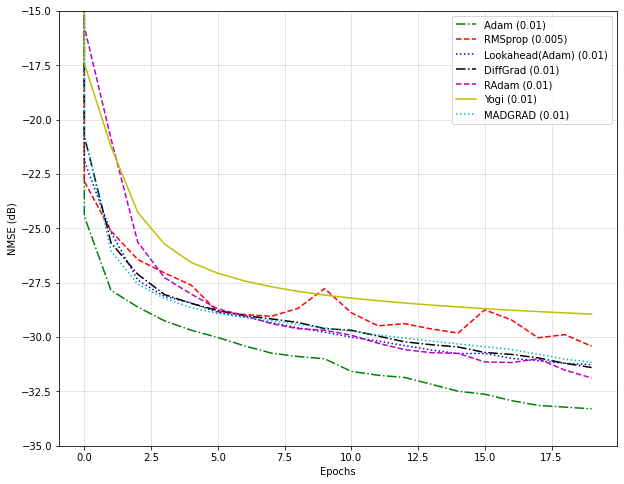

In [42]:
plt.figure(figsize=(10, 8))

plt.plot(adam_log['iter'], adam_log['train_loss_db'], 'g-.', label="Adam (0.01)")
plt.plot(rmsprop_log['iter'], rmsprop_log['train_loss_db'], 'r--', label="RMSprop (0.005)")
plt.plot(laadam_log['iter'], laadam_log['train_loss_db'], 'b:', label="Lookahead(Adam) (0.01)")
plt.plot(diffgrad_log['iter'], diffgrad_log['train_loss_db'], 'k-.', label="DiffGrad (0.01)")
plt.plot(radam_log['iter'], radam_log['train_loss_db'], 'm--', label="RAdam (0.01)")
plt.plot(yogi_log['iter'], yogi_log['train_loss_db'], 'y', label="Yogi (0.01)")
plt.plot(madgrad_log['iter'], madgrad_log['train_loss_db'], 'c:', label="MADGRAD (0.01)")

plt.xlabel('Epochs')
plt.ylabel('NMSE (dB)')
plt.ylim(-35, -15)
plt.grid(alpha=0.4)
plt.legend()
plt.show()